In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Introduction

In this notebook we will remind ourselves of everything we have learned in the course, and we put YOU in the place of a black-box optimizer. Throughout, we will be asking you to query black-box functions manually, to try and find intuition for the way Bayesian Optimization works.

We begin with 'The Bayesian Optimization Problem', where we try to put ourselves in the place of a black-box optimizer. This gives us an intuitive understanding of why the problem is difficult, and how we may be able to solve it.

We then introduce the idea of surrogate models, and show how they can act as guides for our belief and uncertainty on modelling black-box problems. With a surrogate model, the task of solving the optimization problem should become easier.

Ideally, by this step you should have developed some 'rules' about the way you use the surrogate model to select the next queries. We can formalize this mathematically, and create a method that automatically chooses the next query - i.e. Bayesian Optimization!

In the final exercises, which you should submit, we ask you to write and explore the properties of two new acquisition functions.

## The Bayesian Optimization Problem

Recall that Bayesian Optimization concerns the problem of maximizing expensive black-box functions. 

In particular, we are trying to find:

$$x_* = \arg\max f(x)$$

We have no information about the function we want to optimise, but we are able to *query* the function at any input location, $x$. We want to try to get as close as possible to the maximum, with the least number of queries as possible. 

To get an intuitive understanding of the problem, and possible solutions, try the exercise below.

Running the cell will activate a loop where you are requested to input a number in the interval [0, 1]. You have ten attempts to try and maximize an unknown function. Since you are dealing with a black-box function, you will only be able to see the queries you have chosen, $x_i$, and the corresponding observations, $f(x_i)$. Re-run the cell as many times as you want, and try to consider the following questions:

1. How is this different from classical optimisation? (hint: can you use gradients?)
2. What are the main difficulties you encounter when optimizing?
3. What strategies have you developed to solve the problem?

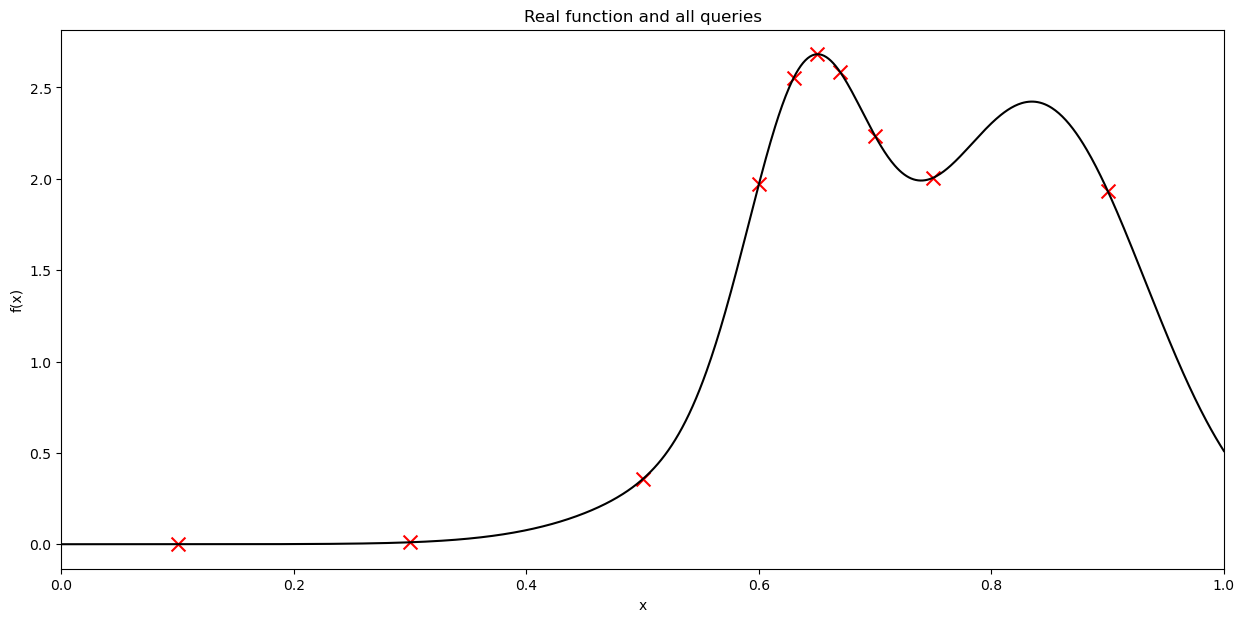

Maximum (by Grid-Search):
2.6817623079595156
Best by Yourself:
2.6817623079595156


In [2]:
# draw a random function parameters
modes = np.random.randint(1, 5)
std = np.random.uniform(low = 0.005, high = 0.05, size = modes)
means = np.random.uniform(size = modes)
amps = np.random.uniform(size = modes) * (2 - 1) + 1

# define function: This is the unknown, black-box function that the user tries to optimize. 
#It takes an input x and returns a value, calculated based on the previously set random parameters.
def calc_function(x):
  exp = -(x - means) ** 2 / std
  y = amps * np.exp(exp)
  return np.sum(y)

# initalise query lists and maximum observations
X, Y = [], []
max_obs = 0

# how many queries in optimisation loop?
num_queries = 10

for i in range(0, num_queries):
  # clear outputs, to keep interface clean
  clear_output(wait = True)
  # initalise plots
  fig, ax = plt.subplots(figsize = (15, 7))
  # set x, y limits, labels and dynamic title
  ax.set_xlim(0, 1)
  ax.set_ylim(0, max(max_obs + 1, 3))
  ax.set_ylabel('f(x)')
  ax.set_xlabel('x')
  ax.set_title('So far you have selected ' + str(i) + ' queries, you have ' + str(10 - i) + ' left.' )
  # plot queries, show plot
  ax.scatter(X, Y, c = 'r', marker='x', s = 100)
  plt.show()
  # initalise x
  x = -1
  # select display format of X and Y
  X_format =  ['%.2f' % query for query in X] # 2 sig figs
  Y_format = ['%.4f' % obs for obs in Y] # 4 sig figs

  while not (0 <= x <= 1): # condition to ensure a number between 0 and 1 is chosen
    data = [(query, obs) for query, obs in zip(X_format, Y_format)]
    print('Data so far (sorted by descending observations): ')
    print('\n'.join('{}: (x, f(x)) = {}'.format(*k) for k in enumerate(data, start = 1))) # display data
    x = float(input('Pick a number between 0 and 1: '))
  # append data, calculate function and sort lists according to observation values
  X.append(x)
  y = calc_function(x)
  Y.append(y)
  X = [x for _, x in sorted(zip(Y, X), reverse = True)]
  Y.sort(reverse = True)
  max_obs = max(max_obs, y)

clear_output()

# calculate function in the grid [0, 0.01, 0.02, ..., 0.98, 0.99, 1]
x_grid = np.linspace(0, 1, 1001)
y_real = []
best_obs_grid = 0
for x in x_grid:
  y = calc_function(x)
  y_real.append(y)
  best_obs_grid = max(best_obs_grid, y) # keep track of best observation


# final plot and display
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(x_grid, y_real, 'k', label = 'f(x)')
ax.scatter(X, Y, c = 'r', marker = 'x', label = 'Queries', s = 100)
ax.set_ylabel('f(x)')
ax.set_xlabel('x')
ax.set_xlim(0, 1)
ax.set_title('Real function and all queries')
plt.show()
print('Maximum (by Grid-Search):')
print(best_obs_grid)
print('Best by Yourself:')
print(max_obs)

# Surrogate Models #

Hopefully by the end of the exercise you began to develop a strategy which leveraged a balance between exploration and exploitation. You explore when you have very little information about a particular area of the search space. You exploit, once you have found a large observation, and begin to investigate the area around. 

Surrogate models allow us to develop an algorithm which is able to 'think' like this. The surrogate model gives us a mathematical representation of our *belief* and *certainty* of how the black-box function looks like. The most common one is the Gaussian Process. Recall its definition:

Consider some space $\mathcal{X}$. Consider a function $\mu: \mathcal{X} \rightarrow \mathbb{R}$, and a *positive semi-definite* function $\kappa : \mathcal{X} \times \mathcal{X} \rightarrow \mathbb{R}$.

We say $f$ follows a Gaussian Process prior with mean function $\mu$ and kernel $\kappa$, if, for any $n \in \mathbb{N}$, and for any collection of distinct points $(x_1, x_2, ..., x_n) := x$, $x_i \in \mathcal{X}$, the random vector $(f(x_1), ..., f(x_n))$ is normally distributed with mean $m(x)$ and covariance matrix $K(x)$ where:

$$
m(x)_i = \mu(x_i)
$$

$$
K(x)_{i, j} = \kappa(x_i, x_j)
$$

We write $f \sim \mathcal{GP}(\mu(x), \kappa(x))$.

What makes Gaussian Processes so desirable, is the fact that we can calculate the posterior analytically, *even under the assumption of noise observations*. To be more precise, assume we have a problem of the form:

$$
 y = f(x) + \epsilon
$$

Where $\epsilon \sim \text{Normal}(0, \sigma_e^2)$ represents the noise. Assume further that $f \sim \mathcal{GP}(\mu_0, \kappa_0)$, and that we are given a data-set of queries and observations, $D_n = \{ (x_i, y_i) : i = 1, ..., n \}$.

It then follows that the posterior, $f \ | \ D_n$, is also a Gaussian Process, with mean and kernel functions given by:

$$
    m_n(x) = \mu_0(x) + k(x)^T( K + \sigma^2 I )^{-1} (Y - m)
$$

$$
    s^2_n(x, x') = \kappa_0(x, x') - k(x)^T ( K + \sigma^2 I ) ^{-1} k(x')
$$

Where: $m_i = \mu_0(x_i), Y_i = y_i, k(x)_i = \kappa_0(x, x_i), K_{ij} = \kappa_0(x_i, x_j)$

We will now repeat the previous exercise, but plotting a surrogate Gaussian Process to fit the selected observations. We will be using an RBF kernel, which has a single parameter (in 1D) called the length-scale. Repeat the exercise a few times. Focus on the following questions:
1. How can you interpret the model? How does the model respond to new observations? Can you justify why it is standard to use zero as a prior mean?
2. Can you think of rule(s) that choose the next point, using only the posterior as reference (i.e. without human intervention)?
3. Play around with the parameters of the problem (see very first lines of code cell). How does changing the lengthscale affect the behaviour of the model? How does it respond to noise?

Note: Recall that the hyper-parameters of the kernel can be chosen by maximum likelihood estimation. We do not do that here, we keep them fixed, so you can get a better understanding of how they affect the model.

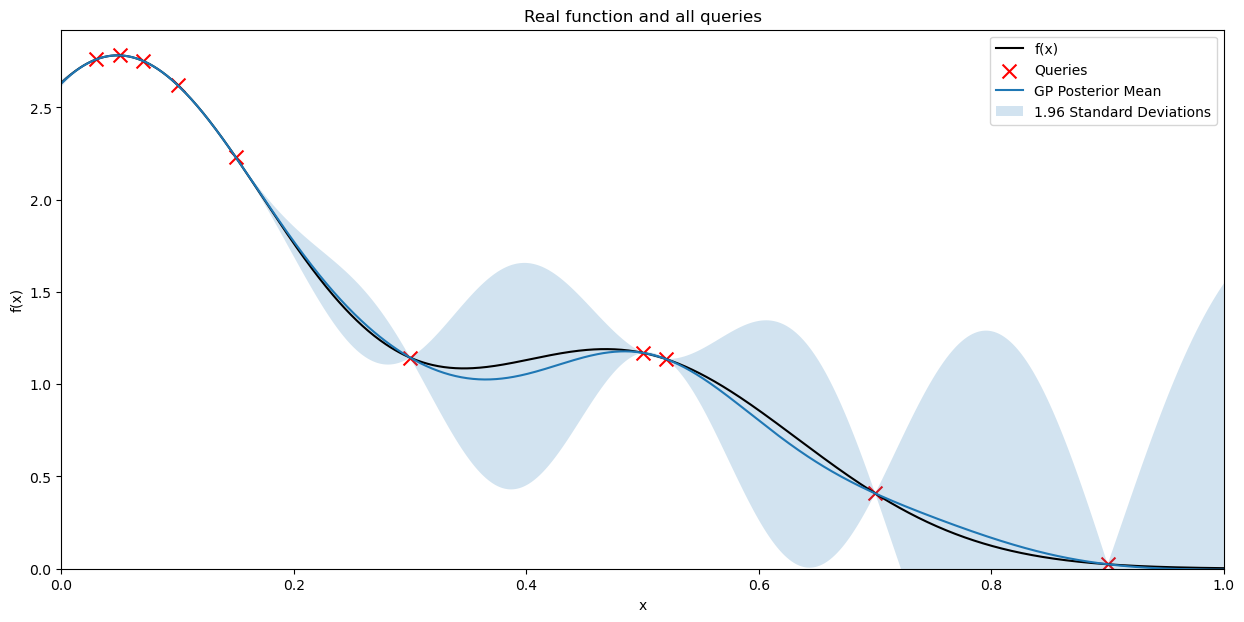

Maximum (by Grid-Search):
2.7821979168331774
Best by Yourself:
2.7820384144030563


In [3]:
# Parameters of the problem. Feel free to change them and play around with them
real_noise_std = 1e-10 # real noise needs to be positive for code to work, instead of zero set 1e-10
noise_assumption = 1e-10 # noise assumption, a hyper-parameter

rbf_lengthscale = 0.1 # lengthscale parameter

# draw a random function parameters
modes = np.random.randint(1, 5)
std = np.random.uniform(low = 0.005, high = 0.05, size = modes)
means = np.random.uniform(size = modes)
amps = np.random.uniform(size = modes) * (2 - 1) + 1

# define function
def calc_function(x):
  exp = -(x - means) ** 2 / std
  y = amps * np.exp(exp)
  return np.sum(y)

# define kernel of GP
#kernel: The GP uses an RBF (Radial Basis Function) kernel, which measures similarity or correlation between points in the input space. 
#The length_scale parameter of the RBF kernel controls how smooth the GP's predictions are; smaller values lead to more wiggly functions, larger values to smoother functions.
kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')
#Alpha: This parameter represents the noise level in the GP model. It's used to add uncertainty to the GP's predictions, which helps the model account for noise in the observations.
model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)
# standard devation for plot
beta = 1.96

# define function
def calc_function(x):
  exp = -(x - means) ** 2 / std
  y = amps * np.exp(exp)
  return np.sum(y)
# initalise query lists and maximum observations
X, Y = [], []
max_obs = 0
# initalise grid for plots
x_grid = np.linspace(0, 1, 101).reshape(-1, 1)

# how many queries in optimisation loop?
num_queries = 10

for i in range(0, num_queries):
  # clear outputs, to keep interface clean
  clear_output(wait = True)
  model = GaussianProcessRegressor(kernel = kernel)
  # fit model
  if i != 0:
    model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
  # calculate mean and standard devation, make them one-dimensional for plotting
  post_mean, post_std = model.predict(x_grid, return_std=True)
  post_mean, post_std = post_mean.squeeze(), post_std.squeeze()

  # initalise plots
  fig, ax = plt.subplots(figsize = (15, 7))
  # set x, y limits, labels and dynamic title
  ax.set_xlim(0, 1)
  ax.set_ylim(0, max(max_obs + 1, 3))
  ax.set_ylabel('f(x)')
  ax.set_xlabel('x')
  ax.set_title('So far you have selected ' + str(i) + ' queries, you have ' + str(10 - i) + ' left.' )
  # plot queries
  ax.scatter(X, Y, c = 'r', marker='x', s = 100)
  # plot mean and standard deviations
  ax.plot(x_grid.squeeze(), post_mean, label = 'GP Posterior Mean')
  ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha = 0.2, label = str(beta) + ' Standard Deviations')
  ax.legend()
  plt.show()
  # initalise x
  x = -1
  # select display format of X and Y
  X_format =  ['%.2f' % query for query in X] # 2 sig figs
  Y_format = ['%.4f' % obs for obs in Y] # 4 sig figs

  while not (0 <= x <= 1): # condition to ensure a number between 0 and 1 is chosen
    data = [(query, obs) for query, obs in zip(X_format, Y_format)]
    print('Data so far (sorted by descending observations): ')
    print('\n'.join('{}: (x, f(x)) = {}'.format(*k) for k in enumerate(data, start = 1))) # display data
    x = float(input('Pick a number between 0 and 1: '))
  # append data, calculate function and sort lists according to observation values
  X.append(x)
  y = calc_function(x) + np.random.normal(scale = real_noise_std)
  Y.append(y)
  X = [x for _, x in sorted(zip(Y, X), reverse = True)]
  Y.sort(reverse = True)
  max_obs = max(max_obs, y)

clear_output()

# calculate function in the grid [0, 0.01, 0.02, ..., 0.98, 0.99, 1]
x_grid = np.linspace(0, 1, 1001)
y_real = []
best_obs_grid = 0
for x in x_grid:
  y = calc_function(x)
  y_real.append(y)
  best_obs_grid = max(best_obs_grid, y) # keep track of best observation


# final GP posterior
model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
post_mean, post_std = model.predict(x_grid.reshape(-1, 1), return_std=True)
post_mean, post_std = post_mean.squeeze(), post_std.squeeze()


# final plot and display
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(x_grid, y_real, 'k', label = 'f(x)')
ax.scatter(X, Y, c = 'r', marker = 'x', label = 'Queries', s = 100)
ax.set_ylabel('f(x)')
ax.set_xlabel('x')
ax.set_xlim(0, 1)
ax.set_ylim(bottom = 0)
ax.set_title('Real function and all queries')
ax.plot(x_grid.squeeze(), post_mean, label = 'GP Posterior Mean')
ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha = 0.2, label = str(beta) + ' Standard Deviations')
ax.legend()
plt.show()
print('Maximum (by Grid-Search):')
print(best_obs_grid)
print('Best by Yourself:')
print(max_obs)

# Acquisition Functions

Once we have built a surrogate model, we can use it to create a rule for choosing the next query. We do this by *maximising* (or minimising) the acquisition function, we can do this because acquisition functions tend to be *much easier* to optimise, it is usually done using a mix of gradient methods or some kind of numerical procedure (e.g. Monte Carlo).

One of the most basic acquisition functions, but very powerful in practice, is called the *upper confidence bound* acquisition function. It is defined by:
$$
\alpha(x | D_n) = m_n(x) + \beta \cdot s_n(x)
$$
Where $\beta$ is a parameter that controls the exploration-exploitation trade-off (higher $\beta$ means more exploration). We can then choose the next point by the rule:
$$
x_{t+1} = \arg\max \alpha(x | D_t)
$$

Run the code below and observe the algorithm in action. Consider the following questions:
1. Can you see the next point that the algorithm will choose?
2. Change the value of $\beta$ at the beginning of the code. How does this affect the behavior of the algorithm?

Note: We will be using grid-search to optimise the acquisition function. In this case, it seems pointless since we can optimise the objective function in the same way, just as fast. Recall that in practice, the objective function is expensive, and takes a long-time to evalutate, therefore grid search is unfeasible. The acquisition function can still be optimized very quickly in practice. 

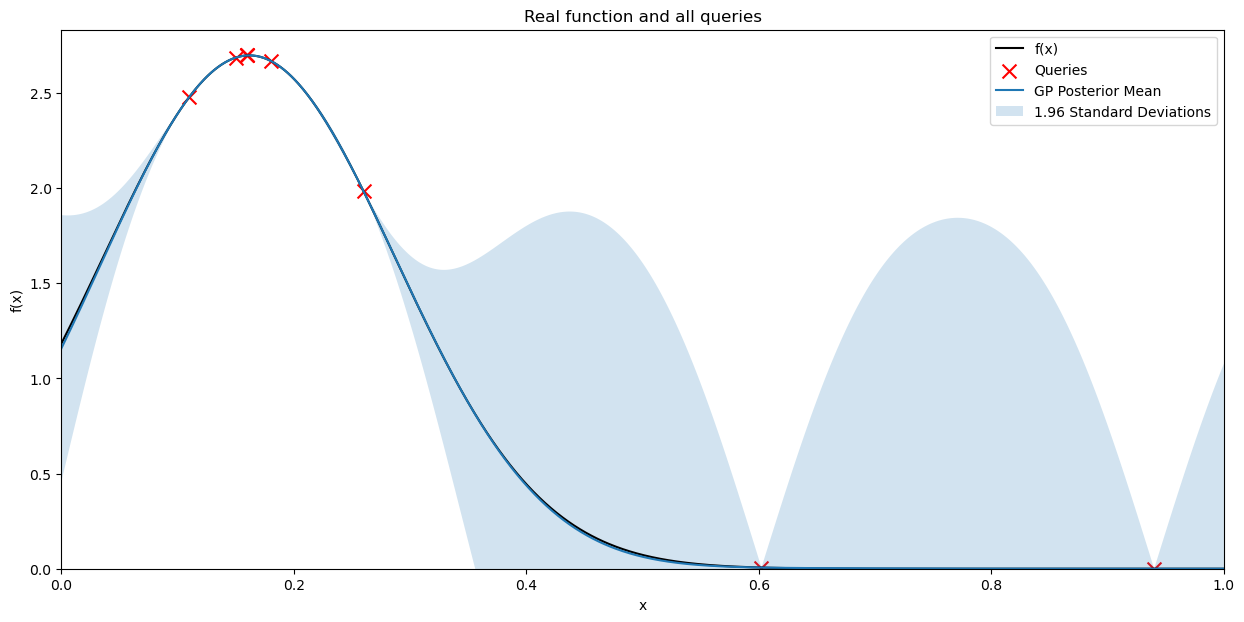

Maximum (by Grid-Search):
2.698187422401831
UCB (Acquisition Function by Grid-Search):
2.697972004719775


In [4]:
# Parameters of the problem. Feel free to change them and play around with them
real_noise_std = 1e-10 # needs to be positive for code to work, instead of zero set 1e-10
noise_assumption = 1e-10

rbf_lengthscale = 0.1

# Acquisition Function Parameter:
#Balances exploration and exploitation by considering both the GP's mean and uncertainty. The beta parameter determines the weight of the uncertainty in the decision-making process.
beta = 1.96

# draw a random function parameters
modes = np.random.randint(1, 5)
std = np.random.uniform(low = 0.005, high = 0.05, size = modes)
means = np.random.uniform(size = modes)
amps = np.random.uniform(size = modes) * (2 - 1) + 1

# define function
def calc_function(x):
  exp = -(x - means) ** 2 / std
  y = amps * np.exp(exp)
  return np.sum(y)

# define kernel of GP
kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')
model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)

# define function
def calc_function(x):
  exp = -(x - means) ** 2 / std
  y = amps * np.exp(exp)
  return np.sum(y)
# initalise query lists and maximum observations
X, Y = [], []
max_obs = 0
# initalise grid for plots
x_grid = np.linspace(0, 1, 101).reshape(-1, 1)

# how many queries in optimisation loop?
num_queries = 10

#Optimization Loop: For a set number of queries, the code fits the GP to the current data, plots the GP mean and uncertainty, and prompts the user to continue to the next point selection.
for i in range(0, num_queries):
  # clear outputs, to keep interface clean
  clear_output(wait = True)
  model = GaussianProcessRegressor(kernel = kernel)
  # fit model
  if i != 0:
    model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
  # calculate mean and standard devation, make them one-dimensional for plotting
  post_mean, post_std = model.predict(x_grid, return_std=True)
  post_mean, post_std = post_mean.squeeze(), post_std.squeeze()

  # initalise plots
  fig, ax = plt.subplots(figsize = (15, 7))
  # set x, y limits, labels and dynamic title
  ax.set_xlim(0, 1)
  ax.set_ylim(0, max(max_obs + 1, 3))
  ax.set_ylabel('f(x)')
  ax.set_xlabel('x')
  ax.set_title('So far you have selected ' + str(i) + ' queries, you have ' + str(10 - i) + ' left.' )
  # plot queries
  ax.scatter(X, Y, c = 'r', marker='x', s = 100)
  # plot mean and standard deviations
  ax.plot(x_grid.squeeze(), post_mean, label = 'GP Posterior Mean')
  ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha = 0.2, label = str(beta) + ' Standard Deviations')
  ax.legend()
  plt.show()
  # initalise x
  x = -1
  # select display format of X and Y
  X_format =  ['%.2f' % query for query in X] # 2 sig figs
  Y_format = ['%.4f' % obs for obs in Y] # 4 sig figs

  data = [(query, obs) for query, obs in zip(X_format, Y_format)]
  print('Data so far (sorted by descending observations): ')
  print('\n'.join('{}: (x, f(x)) = {}'.format(*k) for k in enumerate(data, start = 1))) # display data
  _ = input('Input anything to see the next chosen point') # we are using this to allow for the user to change plots

  # MODIFY THE CODE IN THIS AREA
  #######################################################
  acquisition_function = post_mean + beta * post_std
  #######################################################
  if i == 0:
    x = np.random.uniform(0, 1) # first observation is chosen randomly
  else:
    grid = x_grid.squeeze()
    #The next point x is chosen by finding the maximum of the acquisition function. 
    x = grid[np.argmax(acquisition_function)] # else use the acquisition function

  # append data, calculate function and sort lists according to observation values
  X.append(x)
  y = calc_function(x) + np.random.normal(scale = real_noise_std)
  Y.append(y)
  X = [x for _, x in sorted(zip(Y, X), reverse = True)]
  Y.sort(reverse = True)
  max_obs = max(max_obs, y)

clear_output()

# calculate function in the grid [0, 0.01, 0.02, ..., 0.98, 0.99, 1]
x_grid = np.linspace(0, 1, 1001)
y_real = []
best_obs_grid = 0
for x in x_grid:
  y = calc_function(x)
  y_real.append(y)
  best_obs_grid = max(best_obs_grid, y) # keep track of best observation


# final GP posterior
model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
post_mean, post_std = model.predict(x_grid.reshape(-1, 1), return_std=True)
post_mean, post_std = post_mean.squeeze(), post_std.squeeze()


# final plot and display
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(x_grid, y_real, 'k', label = 'f(x)')
ax.scatter(X, Y, c = 'r', marker = 'x', label = 'Queries', s = 100)
ax.set_ylabel('f(x)')
ax.set_xlabel('x')
ax.set_xlim(0, 1)
ax.set_ylim(bottom = 0)
ax.set_title('Real function and all queries')
ax.plot(x_grid.squeeze(), post_mean, label = 'GP Posterior Mean')
ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha = 0.2, label = str(beta) + ' Standard Deviations')
ax.legend()
plt.show()
print('Maximum (by Grid-Search):')
print(best_obs_grid)
print('UCB (Acquisition Function by Grid-Search):')
print(max_obs)

# Exercises

1. Modify the code in the cell directly above to implement an acquisition function which selects the point with the largest posterior *variance*. Alternately, you can use the standard deviation.

More challenging:

2. An intuitive acquisition function is called 'Probabilty of Improvement' (PI). It is given by:
$$ \alpha(x)_{PI} = \mathbb{P}(f(x) > y_{max})$$
Where $y_{max}$ is our best observation so far. Code this acquisition function.

3. You may have found that PI is *very exploitative*. Fix this, by adding an 'exploration term':
$$ \alpha(x)_{\eta PI} = \mathbb{P}(x > y_{max} + \eta)$$
How does it compare now? How may you go about choosing this parameter?

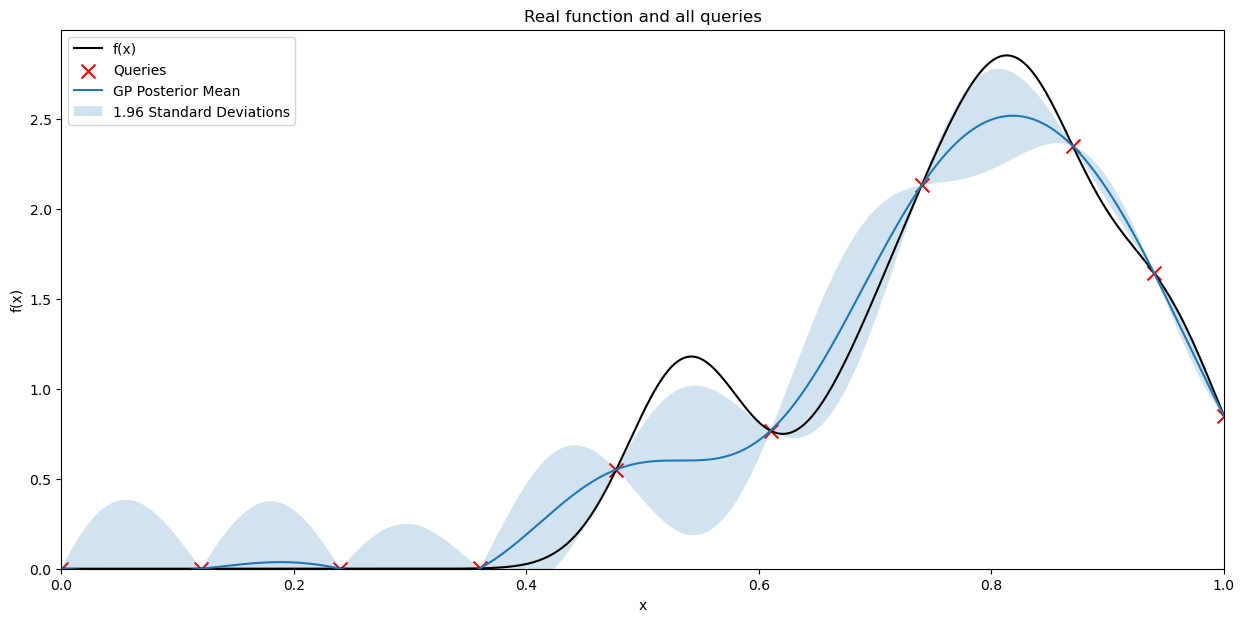

Maximum (by Grid-Search):
2.852124192335665
UCB (Acquisition Function by Grid-Search):
2.3485918188086097


In [5]:
#Modify the code in the cell directly above to implement an acquisition function which selects the point with the largest posterior variance. Alternately, you can use the standard deviation.

# Parameters of the problem. Feel free to change them and play around with them
real_noise_std = 1e-10 # needs to be positive for code to work, instead of zero set 1e-10
noise_assumption = 1e-10

rbf_lengthscale = 0.1

# Acquisition Function Parameter:
#Balances exploration and exploitation by considering both the GP's mean and uncertainty. The beta parameter determines the weight of the uncertainty in the decision-making process.
beta = 1.96

# draw a random function parameters
modes = np.random.randint(1, 5)
std = np.random.uniform(low = 0.005, high = 0.05, size = modes)
means = np.random.uniform(size = modes)
amps = np.random.uniform(size = modes) * (2 - 1) + 1

# define function
def calc_function(x):
  exp = -(x - means) ** 2 / std
  y = amps * np.exp(exp)
  return np.sum(y)

# define kernel of GP
kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')
model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)

# define function
def calc_function(x):
  exp = -(x - means) ** 2 / std
  y = amps * np.exp(exp)
  return np.sum(y)
# initalise query lists and maximum observations
X, Y = [], []
max_obs = 0
# initalise grid for plots
x_grid = np.linspace(0, 1, 101).reshape(-1, 1)

# how many queries in optimisation loop?
num_queries = 10

#Optimization Loop: For a set number of queries, the code fits the GP to the current data, plots the GP mean and uncertainty, and prompts the user to continue to the next point selection.
for i in range(0, num_queries):
  # clear outputs, to keep interface clean
  clear_output(wait = True)
  model = GaussianProcessRegressor(kernel = kernel)
  # fit model
  if i != 0:
    model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
  # calculate mean and standard devation, make them one-dimensional for plotting
  post_mean, post_std = model.predict(x_grid, return_std=True)
  post_mean, post_std = post_mean.squeeze(), post_std.squeeze()

  # initalise plots
  fig, ax = plt.subplots(figsize = (15, 7))
  # set x, y limits, labels and dynamic title
  ax.set_xlim(0, 1)
  ax.set_ylim(0, max(max_obs + 1, 3))
  ax.set_ylabel('f(x)')
  ax.set_xlabel('x')
  ax.set_title('So far you have selected ' + str(i) + ' queries, you have ' + str(10 - i) + ' left.' )
  # plot queries
  ax.scatter(X, Y, c = 'r', marker='x', s = 100)
  # plot mean and standard deviations
  ax.plot(x_grid.squeeze(), post_mean, label = 'GP Posterior Mean')
  ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha = 0.2, label = str(beta) + ' Standard Deviations')
  ax.legend()
  plt.show()
  # initalise x
  x = -1
  # select display format of X and Y
  X_format =  ['%.2f' % query for query in X] # 2 sig figs
  Y_format = ['%.4f' % obs for obs in Y] # 4 sig figs

  data = [(query, obs) for query, obs in zip(X_format, Y_format)]
  print('Data so far (sorted by descending observations): ')
  print('\n'.join('{}: (x, f(x)) = {}'.format(*k) for k in enumerate(data, start = 1))) # display data
  _ = input('Input anything to see the next chosen point') # we are using this to allow for the user to change plots

  # MODIFY THE CODE IN THIS AREA
  #######################################################
  acquisition_function = post_std
  #######################################################
  if i == 0:
    x = np.random.uniform(0, 1) # first observation is chosen randomly
  else:
    grid = x_grid.squeeze()
    #The next point x is chosen by finding the maximum of the acquisition function. 
    x = grid[np.argmax(acquisition_function)] # else use the acquisition function

  # append data, calculate function and sort lists according to observation values
  X.append(x)
  y = calc_function(x) + np.random.normal(scale = real_noise_std)
  Y.append(y)
  X = [x for _, x in sorted(zip(Y, X), reverse = True)]
  Y.sort(reverse = True)
  max_obs = max(max_obs, y)

clear_output()

# calculate function in the grid [0, 0.01, 0.02, ..., 0.98, 0.99, 1]
x_grid = np.linspace(0, 1, 1001)
y_real = []
best_obs_grid = 0
for x in x_grid:
  y = calc_function(x)
  y_real.append(y)
  best_obs_grid = max(best_obs_grid, y) # keep track of best observation


# final GP posterior
model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
post_mean, post_std = model.predict(x_grid.reshape(-1, 1), return_std=True)
post_mean, post_std = post_mean.squeeze(), post_std.squeeze()


# final plot and display
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(x_grid, y_real, 'k', label = 'f(x)')
ax.scatter(X, Y, c = 'r', marker = 'x', label = 'Queries', s = 100)
ax.set_ylabel('f(x)')
ax.set_xlabel('x')
ax.set_xlim(0, 1)
ax.set_ylim(bottom = 0)
ax.set_title('Real function and all queries')
ax.plot(x_grid.squeeze(), post_mean, label = 'GP Posterior Mean')
ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha = 0.2, label = str(beta) + ' Standard Deviations')
ax.legend()
plt.show()
print('Maximum (by Grid-Search):')
print(best_obs_grid)
print('UCB (Acquisition Function by Grid-Search):')
print(max_obs)

# Exercises

More challenging:

2. An intuitive acquisition function is called 'Probabilty of Improvement' (PI). It is given by:
$$ \alpha(x)_{PI} = \mathbb{P}(f(x) > y_{max})$$
Where $y_{max}$ is our best observation so far. Code this acquisition function.


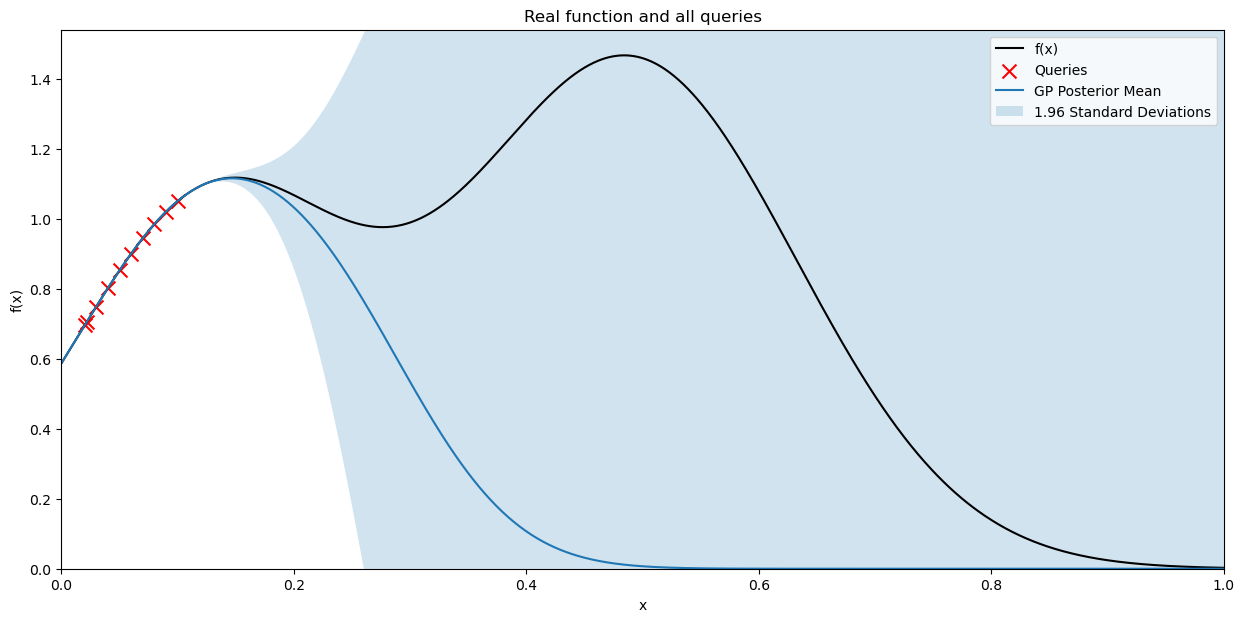

Maximum (by Grid-Search):
1.4669525292738876
UCB (Acquisition Function by Grid-Search):
1.0505588208155896


In [2]:
from scipy.stats import norm

# Parameters of the problem. Feel free to change them and play around with them
real_noise_std = 1e-10 # needs to be positive for code to work, instead of zero set 1e-10
noise_assumption = 1e-10

rbf_lengthscale = 0.1

# Acquisition Function Parameter:
#Balances exploration and exploitation by considering both the GP's mean and uncertainty. The beta parameter determines the weight of the uncertainty in the decision-making process.
beta = 1.96

# draw a random function parameters
modes = np.random.randint(1, 5)
std = np.random.uniform(low = 0.005, high = 0.05, size = modes)
means = np.random.uniform(size = modes)
amps = np.random.uniform(size = modes) * (2 - 1) + 1

# define function
def calc_function(x):
  exp = -(x - means) ** 2 / std
  y = amps * np.exp(exp)
  return np.sum(y)

# define kernel of GP
kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')
model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)


# initalise query lists and maximum observations
X, Y = [], []
max_obs = 0
# initalise grid for plots
x_grid = np.linspace(0, 1, 101).reshape(-1, 1)

# Initialise y_max before the loop
y_max = -np.inf

# how many queries in optimisation loop?
num_queries = 10

#Optimization Loop: For a set number of queries, the code fits the GP to the current data, plots the GP mean and uncertainty, and prompts the user to continue to the next point selection.
for i in range(0, num_queries):
  # clear outputs, to keep interface clean
  clear_output(wait = True)
  model = GaussianProcessRegressor(kernel = kernel)
  
  # fit model
  if i != 0:
    model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
    
  # INSERT THE SNIPPET HERE
  if i > 0:
    y_max = max(Y)  # The best observation so far   
    
  # calculate mean and standard devation, make them one-dimensional for plotting
  post_mean, post_std = model.predict(x_grid, return_std=True)
  post_mean, post_std = post_mean.squeeze(), post_std.squeeze()

  # initalise plots
  fig, ax = plt.subplots(figsize = (15, 7))
  # set x, y limits, labels and dynamic title
  ax.set_xlim(0, 1)
  ax.set_ylim(0, max(max_obs + 1, 3))
  ax.set_ylabel('f(x)')
  ax.set_xlabel('x')
  ax.set_title('So far you have selected ' + str(i) + ' queries, you have ' + str(10 - i) + ' left.' )
  # plot queries
  ax.scatter(X, Y, c = 'r', marker='x', s = 100)
  # plot mean and standard deviations
  ax.plot(x_grid.squeeze(), post_mean, label = 'GP Posterior Mean')
  ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha = 0.2, label = str(beta) + ' Standard Deviations')
  ax.legend()
  plt.show()
  # initalise x
  x = -1
  # select display format of X and Y
  X_format =  ['%.2f' % query for query in X] # 2 sig figs
  Y_format = ['%.4f' % obs for obs in Y] # 4 sig figs

  data = [(query, obs) for query, obs in zip(X_format, Y_format)]
  print('Data so far (sorted by descending observations): ')
  print('\n'.join('{}: (x, f(x)) = {}'.format(*k) for k in enumerate(data, start = 1))) # display data
  _ = input('Input anything to see the next chosen point') # we are using this to allow for the user to change plots

  # MODIFY THE CODE IN THIS AREA
  #######################################################
    # Assuming y_max is defined as the best observation so far
    # Calculate the Z value for the PI acquisition function
  Z = (post_mean - y_max) / post_std
    
    # Probability of Improvement for each point in the grid
    # Compute the PI acquisition function
  acquisition_function = norm.cdf(Z)
    
    
  #######################################################

  if i == 0:
    x = np.random.uniform(0, 1) # first observation is chosen randomly
  else:
    grid = x_grid.squeeze()
    #The next point x is chosen by finding the maximum of the acquisition function. 
    x = grid[np.argmax(acquisition_function)] # else use the acquisition function

  # append data, calculate function and sort lists according to observation values
  X.append(x)
  y = calc_function(x) + np.random.normal(scale = real_noise_std)
  Y.append(y)
  X = [x for _, x in sorted(zip(Y, X), reverse = True)]
  Y.sort(reverse = True)
  max_obs = max(max_obs, y)

clear_output()

# calculate function in the grid [0, 0.01, 0.02, ..., 0.98, 0.99, 1]
x_grid = np.linspace(0, 1, 1001)
y_real = []
best_obs_grid = 0
for x in x_grid:
  y = calc_function(x)
  y_real.append(y)
  best_obs_grid = max(best_obs_grid, y) # keep track of best observation


# final GP posterior
model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
post_mean, post_std = model.predict(x_grid.reshape(-1, 1), return_std=True)
post_mean, post_std = post_mean.squeeze(), post_std.squeeze()


# final plot and display
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(x_grid, y_real, 'k', label = 'f(x)')
ax.scatter(X, Y, c = 'r', marker = 'x', label = 'Queries', s = 100)
ax.set_ylabel('f(x)')
ax.set_xlabel('x')
ax.set_xlim(0, 1)
ax.set_ylim(bottom = 0)
ax.set_title('Real function and all queries')
ax.plot(x_grid.squeeze(), post_mean, label = 'GP Posterior Mean')
ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha = 0.2, label = str(beta) + ' Standard Deviations')
ax.legend()
plt.show()
print('Maximum (by Grid-Search):')
print(best_obs_grid)
print('Probabilty of Improvement(PI) (Acquisition Function by Grid-Search):')
print(max_obs)

# Exercises

More challenging:

3. You may have found that PI is *very exploitative*. Fix this, by adding an 'exploration term':
$$ \alpha(x)_{\eta PI} = \mathbb{P}(x > y_{max} + \eta)$$
How does it compare now? How may you go about choosing this parameter?

In [ ]:
from scipy.stats import norm

# Parameters of the problem. Feel free to change them and play around with them
real_noise_std = 1e-10 # needs to be positive for code to work, instead of zero set 1e-10
noise_assumption = 1e-10

rbf_lengthscale = 0.1

# Acquisition Function Parameter:
#Balances exploration and exploitation by considering both the GP's mean and uncertainty. The beta parameter determines the weight of the uncertainty in the decision-making process.
beta = 1.96

xi = 0.01  # Exploration parameter for PI acquisition function

# draw a random function parameters
modes = np.random.randint(1, 5)
std = np.random.uniform(low = 0.005, high = 0.05, size = modes)
means = np.random.uniform(size = modes)
amps = np.random.uniform(size = modes) * (2 - 1) + 1

# define function
def calc_function(x):
  exp = -(x - means) ** 2 / std
  y = amps * np.exp(exp)
  return np.sum(y)

# define kernel of GP
kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')
model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)


# initalise query lists and maximum observations
X, Y = [], []
max_obs = 0
# initalise grid for plots
x_grid = np.linspace(0, 1, 101).reshape(-1, 1)

# Initialise y_max before the loop
y_max = -np.inf

# how many queries in optimisation loop?
num_queries = 10

#Optimization Loop: For a set number of queries, the code fits the GP to the current data, plots the GP mean and uncertainty, and prompts the user to continue to the next point selection.
for i in range(0, num_queries):
  # clear outputs, to keep interface clean
  clear_output(wait = True)
  model = GaussianProcessRegressor(kernel = kernel)
  
  # fit model
  if i != 0:
    model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
    
  # INSERT THE SNIPPET HERE
  if i > 0:
    y_max = max(Y)  # The best observation so far   
    xi = 0.01
    
  # calculate mean and standard devation, make them one-dimensional for plotting
  post_mean, post_std = model.predict(x_grid, return_std=True)
  post_mean, post_std = post_mean.squeeze(), post_std.squeeze()

  # initalise plots
  fig, ax = plt.subplots(figsize = (15, 7))
  # set x, y limits, labels and dynamic title
  ax.set_xlim(0, 1)
  ax.set_ylim(0, max(max_obs + 1, 3))
  ax.set_ylabel('f(x)')
  ax.set_xlabel('x')
  ax.set_title('So far you have selected ' + str(i) + ' queries, you have ' + str(10 - i) + ' left.' )
  # plot queries
  ax.scatter(X, Y, c = 'r', marker='x', s = 100)
  # plot mean and standard deviations
  ax.plot(x_grid.squeeze(), post_mean, label = 'GP Posterior Mean')
  ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha = 0.2, label = str(beta) + ' Standard Deviations')
  ax.legend()
  plt.show()
  # initalise x
  x = -1
  # select display format of X and Y
  X_format =  ['%.2f' % query for query in X] # 2 sig figs
  Y_format = ['%.4f' % obs for obs in Y] # 4 sig figs

  data = [(query, obs) for query, obs in zip(X_format, Y_format)]
  print('Data so far (sorted by descending observations): ')
  print('\n'.join('{}: (x, f(x)) = {}'.format(*k) for k in enumerate(data, start = 1))) # display data
  _ = input('Input anything to see the next chosen point') # we are using this to allow for the user to change plots

  # MODIFY THE CODE IN THIS AREA
  #######################################################
    # Assuming y_max is defined as the best observation so far
    # Calculate the Z value for the PI acquisition function
  Z = (post_mean - y_max -xi) / post_std
    
    # Probability of Improvement for each point in the grid
    # Compute the PI acquisition function
  acquisition_function = norm.cdf(Z)
    
    
  #######################################################

  if i == 0:
    x = np.random.uniform(0, 1) # first observation is chosen randomly
  else:
    grid = x_grid.squeeze()
    #The next point x is chosen by finding the maximum of the acquisition function. 
    x = grid[np.argmax(acquisition_function)] # else use the acquisition function

  # append data, calculate function and sort lists according to observation values
  X.append(x)
  y = calc_function(x) + np.random.normal(scale = real_noise_std)
  Y.append(y)
  X = [x for _, x in sorted(zip(Y, X), reverse = True)]
  Y.sort(reverse = True)
  max_obs = max(max_obs, y)

clear_output()

# calculate function in the grid [0, 0.01, 0.02, ..., 0.98, 0.99, 1]
x_grid = np.linspace(0, 1, 1001)
y_real = []
best_obs_grid = 0
for x in x_grid:
  y = calc_function(x)
  y_real.append(y)
  best_obs_grid = max(best_obs_grid, y) # keep track of best observation


# final GP posterior
model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
post_mean, post_std = model.predict(x_grid.reshape(-1, 1), return_std=True)
post_mean, post_std = post_mean.squeeze(), post_std.squeeze()


# final plot and display
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(x_grid, y_real, 'k', label = 'f(x)')
ax.scatter(X, Y, c = 'r', marker = 'x', label = 'Queries', s = 100)
ax.set_ylabel('f(x)')
ax.set_xlabel('x')
ax.set_xlim(0, 1)
ax.set_ylim(bottom = 0)
ax.set_title('Real function and all queries')
ax.plot(x_grid.squeeze(), post_mean, label = 'GP Posterior Mean')
ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha = 0.2, label = str(beta) + ' Standard Deviations')
ax.legend()
plt.show()
print('Maximum (by Grid-Search):')
print(best_obs_grid)
print('Probabilty of Improvement(PI) with an exploration term (Acquisition Function by Grid-Search):')
print(max_obs)